In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras
from keras.applications.vgg16 import preprocess_input as vgg16_preproc
from skimage.transform import resize
from keras.models import model_from_json
from keras.utils.vis_utils import plot_model
from glob import glob
import os
from itertools import chain
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import math

Using TensorFlow backend.


In [2]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename):  
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)
    
    if ds.Modality != 'DX':
        print(f'Image rejected. Reason: modality is {ds.Modality}.\n')
        return None, ds.StudyDescription
    
    if ds.BodyPartExamined != 'CHEST':
        print(f'Image rejected. Reason: body part is {ds.BodyPartExamined}\n')
        return None, ds.StudyDescription
    
    if ds.PatientPosition not in ['AP', 'PA']:
        print(f'Image rejected. Reason: position is {ds.PatientPosition}.\n' )
        return None, ds.StudyDescription
    
    img = ds.pixel_array
    return img, ds.StudyDescription
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img, img_mean, img_std, img_size): 
    proc_img = img / 255.0
    proc_img = resize(proc_img, (img_size[1], img_size[2]), anti_aliasing=False)
    proc_img = proc_img.reshape((img_size[0], img_size[1], img_size[2], 1))
    proc_img = np.repeat(proc_img, img_size[3], axis=3)
    proc_img = vgg16_preproc(proc_img)
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    json_file = open(model_path, 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    model.load_weights(weight_path)   
    #model = model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    prob = model.predict(img)
    pred= prob > thresh
    return pred[0][0]

In [3]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'model_vgg.json'
weight_path = 'xray_class_my_model_vgg.best1.hdf5'

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16
img_mean = -1 # loads the mean image value they used during training preprocessing
img_std = -1 # loads the std dev image value they used during training preprocessing

my_model = load_model(model_path, weight_path) #loads model
thresh = 0.39 

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img, study_description = check_dicom(i)
    if img is None:
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model, img_proc, thresh)
    print(f'Prediction: {"No pneumonia" if pred == False else "Pneumonia"}')
    print(f'Actual: {study_description}\n')
    

Load file test1.dcm ...
Prediction: No pneumonia
Actual: No Finding

Load file test2.dcm ...
Prediction: No pneumonia
Actual: Cardiomegaly

Load file test3.dcm ...
Prediction: No pneumonia
Actual: Effusion

Load file test4.dcm ...
Image rejected. Reason: body part is RIBCAGE

Load file test5.dcm ...
Image rejected. Reason: modality is CT.

Load file test6.dcm ...
Image rejected. Reason: position is XX.



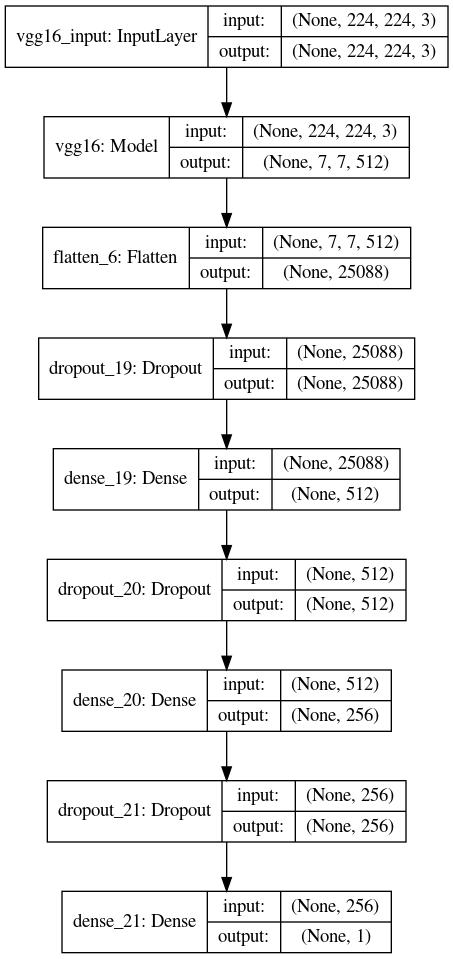

In [4]:
plot_model(my_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Additional Inference

Lets run inference in the presence of all the other conditions and see where ruling in or out pneumonia fails.

In [5]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('../p1_data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('../p1_data','images*', '*', '*.png'))}

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

labels = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
unique_labels = np.unique(list(chain(*labels)))

for ul in unique_labels:
    all_xray_df[ul] = all_xray_df['Finding Labels'].map(lambda findings: 1 if ul in findings else 0)
all_xray_df.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
38770,00010120_026.png,Consolidation,26,10120,53,M,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,0
57712,00014299_009.png,Emphysema,9,14299,44,F,PA,2992,2991,0.143000,...,1,0,0,0,0,0,0,0,0,0
42478,00010932_007.png,No Finding,7,10932,56,M,PA,2894,2991,0.143000,...,0,0,0,0,0,1,0,0,0,0
108080,00029247_000.png,Atelectasis|Infiltration,0,29247,70,M,PA,2021,2021,0.194311,...,0,0,0,1,0,0,0,0,0,0
78704,00019308_006.png,Atelectasis|Effusion|Infiltration,6,19308,61,F,AP,2500,2048,0.168000,...,0,0,0,1,0,0,0,0,0,0
31026,00008067_007.png,Infiltration,7,8067,44,M,AP,2500,2048,0.168000,...,0,0,0,1,0,0,0,0,0,0
86602,00021368_000.png,Atelectasis,0,21368,43,M,PA,2858,2909,0.143000,...,0,0,0,0,0,0,0,0,0,0
84686,00020852_002.png,Atelectasis|Infiltration,2,20852,75,M,AP,3056,2544,0.139000,...,0,0,0,1,0,0,0,0,0,0
92346,00023068_039.png,No Finding,39,23068,72,F,AP,3056,2544,0.139000,...,0,0,0,0,0,1,0,0,0,0
26998,00007034_075.png,Fibrosis|Pneumothorax,75,7034,26,F,AP,3056,2544,0.139000,...,0,1,0,0,0,0,0,0,0,1


In [31]:
def make_generator(df, condition, preprocess_input):
    idg = ImageDataGenerator(rescale= 1.0/255.0, preprocessing_function=preprocess_input)

    
    gen = idg.flow_from_dataframe(dataframe=df, directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'Pneumonia',
                                                 class_mode = 'raw',
                                                 target_size = (224, 224), 
                                                 batch_size = 512
                                                )
    return gen

def getXY(df, condition):
    generator = make_generator(df, condition, vgg16_preproc)
    return generator.next() 

def getConfusion(y, pred_y):
    tn, fp, fn, tp = confusion_matrix(y, (pred_y > thresh).astype(int)).ravel()
    
    recall = tp / (tp + fn) 
    precision = tp / (tp + fp)
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn)
    
    if math.isnan(recall):
        recall = 0
    
    if math.isnan(precision):
        precision = 0
    
    if math.isnan(specificity):
        specificity = 0
        
    if math.isnan(npv):
        npv = 0
    
    print(f'True neg: {tn}; True pos: {tp}; False neg: {fn}; False pos: {fp}')
    print(f'Recall/sensitivity: {recall} ... Specificity: {specificity} \nPrecision: {precision} ... NPV: {npv}')
    
    return tn, tp, fn, fp

In [36]:
def infer_with_other_diseases():
    for condition in unique_labels:      
        
        print("CONDITION:", condition)

        df_pos, df_neg = None, None

        if condition == 'Pneumonia' or condition == 'No Finding':
            df_pos = all_xray_df[(all_xray_df[condition] == 1)] 
            df_neg = all_xray_df[(all_xray_df[condition] == 0)] 
        else:  
            df_pos = all_xray_df.loc[(all_xray_df[condition] == 1) & (all_xray_df.Pneumonia == 1)] 
            df_neg = all_xray_df.loc[(all_xray_df[condition] == 1) & (all_xray_df.Pneumonia == 0)] 

        for i, df in enumerate([df_pos, df_neg]):
            if condition == 'No Finding':
                if i == 0:
                    print('Healthy')
                elif i == 1:
                    print('\nSome unknown condition is present')
            else:
                if i == 0:
                    print('Pneumonia positive')
                elif i == 1:
                    print('\nPneumonia negative')

            X, Y = getXY(df, condition)
            predictions = my_model.predict(X, batch_size = 32, verbose = True)
            getConfusion(Y, predictions) 
        print('--------\n\n')            

In [37]:
infer_with_other_diseases() 

CONDITION: Atelectasis
Pneumonia positive
Found 262 validated image filenames.
262/262 [==============================] - 1s 2ms/step
True neg: 0; True pos: 135; False neg: 127; False pos: 0
Recall/sensitivity: 0.5152671755725191 ... Specificity: 0 
Precision: 1.0 ... NPV: 0.0

Pneumonia negative
Found 11297 validated image filenames.


<ipython-input-31-849969229cc8>:23: RuntimeWarning: invalid value encountered in long_scalars
  specificity = tn / (tn + fp)


512/512 [==============================] - 1s 2ms/step
True neg: 232; True pos: 0; False neg: 0; False pos: 280
Recall/sensitivity: 0 ... Specificity: 0.453125 
Precision: 0.0 ... NPV: 1.0
--------


CONDITION: Cardiomegaly
Pneumonia positive
Found 41 validated image filenames.


<ipython-input-31-849969229cc8>:21: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)


41/41 [==============================] - 0s 2ms/step
True neg: 0; True pos: 30; False neg: 11; False pos: 0
Recall/sensitivity: 0.7317073170731707 ... Specificity: 0 
Precision: 1.0 ... NPV: 0.0

Pneumonia negative
Found 2735 validated image filenames.
512/512 [==============================] - 1s 2ms/step
True neg: 245; True pos: 0; False neg: 0; False pos: 267
Recall/sensitivity: 0 ... Specificity: 0.478515625 
Precision: 0.0 ... NPV: 1.0
--------


CONDITION: Consolidation
Pneumonia positive
Found 123 validated image filenames.
123/123 [==============================] - 0s 2ms/step
True neg: 0; True pos: 95; False neg: 28; False pos: 0
Recall/sensitivity: 0.7723577235772358 ... Specificity: 0 
Precision: 1.0 ... NPV: 0.0

Pneumonia negative
Found 4544 validated image filenames.
512/512 [==============================] - 1s 2ms/step
True neg: 140; True pos: 0; False neg: 0; False pos: 372
Recall/sensitivity: 0 ... Specificity: 0.2734375 
Precision: 0.0 ... NPV: 1.0
--------


CONDITI

<ipython-input-31-849969229cc8>:22: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


224/224 [==============================] - 0s 2ms/step
True neg: 176; True pos: 0; False neg: 0; False pos: 48
Recall/sensitivity: 0 ... Specificity: 0.7857142857142857 
Precision: 0.0 ... NPV: 1.0
--------


CONDITION: Infiltration
Pneumonia positive
Found 605 validated image filenames.
512/512 [==============================] - 1s 2ms/step
True neg: 0; True pos: 374; False neg: 138; False pos: 0
Recall/sensitivity: 0.73046875 ... Specificity: 0 
Precision: 1.0 ... NPV: 0.0

Pneumonia negative
Found 19289 validated image filenames.
512/512 [==============================] - 1s 2ms/step
True neg: 235; True pos: 0; False neg: 0; False pos: 277
Recall/sensitivity: 0 ... Specificity: 0.458984375 
Precision: 0.0 ... NPV: 1.0
--------


CONDITION: Mass
Pneumonia positive
Found 71 validated image filenames.
71/71 [==============================] - 0s 2ms/step
True neg: 0; True pos: 49; False neg: 22; False pos: 0
Recall/sensitivity: 0.6901408450704225 ... Specificity: 0 
Precision: 1.0 ... N